# EVOLUTIVE FDI (EFDI)

In [1]:
from river import preprocessing, ensemble, neighbors, datasets, utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import OrderedDict
from pprint import pprint

In [2]:
# Carregando o CSV para DataFrame
dataset_original = pd.read_csv(datasets.ImageSegments().path)

#Realizando o LabelEncoder da variável dependente
dataset_original['categorical_label'] = LabelEncoder().fit_transform(dataset_original['category'])

# Dados != PATH
df_train = dataset_original[dataset_original['category'] != 'path']

# Dados == PATH
category_path = dataset_original[dataset_original['category'] == 'path']

Y_train_simbolic = df_train.pop('category')
Y_train_numeric = df_train.pop('categorical_label')

## METODOLOGIA

### DEFINIR DATASETS

S1 = {brickface, cement, foliage, grass, sky, window}

S1_1 = 70% S1 (de cada classe)

S1_2 = 30% S1 (de cada classe)

S2 = {path}

S2_1 = 30% S2

S2_2 = 70% S2

S3 = {S1_2 + S2_2)

### APLICAR METODOLOGIA

1. train S1_1

2. predict S2_1

3. cluster S2_1

4. train S2_1

5. validar S3 => métricas acurácia

6. Anomaly Detection (detector phase)


### PREPARANDO DADOS

In [3]:
#TODAS AS AMOSTRAS (EXCETO PATH)
S1 = dataset_original[dataset_original['category'] != 'path']

#TRAIN / TEST ESTRATIFICADO
X_train, X_test, y_train, y_test = train_test_split(S1.iloc[:,:-2], S1.iloc[:, -1], stratify=S1.iloc[:, -1], test_size=0.3)

#70% CADA CLASSE (EXCETO PATH)
S1_1 = pd.concat([X_train,y_train], axis=1)
S1_1_x = S1_1.iloc[:, :-1]
S1_1_y = S1_1.iloc[:, -1]

#30% CADA CLASSE (EXCETO PATH)
S1_2 = pd.concat([X_test, y_test], axis=1)

#PATH
S2 = dataset_original[dataset_original['category'] == 'path']

X_train, X_test, y_train, y_test = train_test_split(S2.iloc[:,:-2], S2.iloc[:, -1], test_size=0.7)

#30% DE PATH
S2_1 = pd.concat([X_train,y_train], axis=1)
S2_1_x = S2_1.iloc[:, :-1]

#70% DE PATH
S2_2 = pd.concat([X_test, y_test], axis=1)

#PATH
S3 = pd.concat([S2_1, S2_2], axis=0)

## DETECTOR PHASE

brickface (0) -> NORMAL

In [4]:
from river import anomaly
from river import preprocessing
from river import compose
from sklearn.preprocessing import MinMaxScaler as sk_minmax

In [5]:
NORMAL_x_train = S1_1.loc[S1_1['categorical_label'] == 0].iloc[:, :-1]
NORMAL_x_test = S1_2.loc[S1_2['categorical_label'] == 0].iloc[:, :-1]

### HalfSpaceTree (RIVER)

In [9]:
from river.utils import numpy2dict

#HIPERPARÂMETROS
inliers = 0
threshold = 0.5

minmax_scaler = sk_minmax()
model = compose.Pipeline(
    anomaly.HalfSpaceTrees(seed=42)
)

x_train = NORMAL_x_train.to_numpy()
x_val = NORMAL_x_test.to_numpy()
x_test = S1[S1['categorical_label'] != 0].iloc[:, :-2].to_numpy()

# INITIAL PHASE
for x in x_train:
    x_scaled = minmax_scaler.partial_fit(x.reshape(1, x.shape[0])).transform(x.reshape(1, x.shape[0]))
    model.learn_one(numpy2dict(x_scaled))

for x in x_val:
    x_scaled = minmax_scaler.transform(x.reshape(1, x.shape[0]))

    score = model.score_one(numpy2dict(x_scaled[0]))

    if (score <= threshold): #low score - normal observation
        inliers = inliers+1

pprint(f'Identificou {inliers/len(x_val)*100:.2f}% de amostras NORMAIS corretamente')

#DETECTOR PHASE
outliers = 0
outliers_map = []
for x in x_test:
    x_scaled = minmax_scaler.transform(x.reshape(1, x.shape[0]))
    score = model.score_one(numpy2dict(x_scaled[0]))

    if (score > threshold):
        outliers = outliers+1
        outliers_map.append(np.array(x).tolist())

    #se outlier -> reverte transformações -> envia para detecção

pprint(f'Identificou {outliers/len(x_test)*100:.2f}% de amostras de falhas corretamente')

'Identificou 100.00% de amostras NORMAIS corretamente'
'Identificou 90.91% de amostras de falhas corretamente'


### OneClass SVM | IF | LOF (SkLearn)

- SUPERVISED AS A BASELINE
- Pode ser utilizado como linha de base para comparação desta fase!
- Resultados foram excelentes

In [9]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

def verify(model, inliers, outliers):
    print(model)
    inliers_detected = 0
    for k, x in enumerate(inliers):
        if (x == 1):
            inliers_detected = inliers_detected+1

    pprint('Identificou ' + str(inliers_detected/len(inliers)*100) + '% de amostras normais corretamente')

    outliers_detected = 0
    for k, x in enumerate(outliers):
        if (x == -1):
            outliers_detected = outliers_detected+1

    pprint('Identificou ' + str(outliers_detected/len(outliers)*100) + '% de amostras de falhas corretamente')
    print('********')

clfs = [
    OneClassSVM(gamma='auto').fit(S2_2.iloc[:, :-1]),
    IsolationForest(random_state=0).fit(S2_2.iloc[:, :-1]),
    LocalOutlierFactor(n_neighbors=2, novelty=True).fit(S2_2.iloc[:, :-1]),
]

for k, clf in enumerate(clfs):
    verify(clf, clf.predict(S2_1.iloc[:, :-1]), clf.predict(S1.iloc[:, :-2]))


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)
'Identificou 7.07070707070707% de amostras normais corretamente'
'Identificou 100.0% de amostras de falhas corretamente'
********
IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)
'Identificou 81.81818181818183% de amostras normais corretamente'
'Identificou 97.02020202020202% de amostras de falhas corretamente'
********
LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=2, novelty=True, p=2)
'Identificou 85.85858585858585% de amostras normais corretamente'
'Identificou 99.4949494949495% de amostras de falhas corretamente'
********


### Send to Classifier

- pegar tudo que foi classificado como FALHA e enviar para CLASSIFIER

In [16]:
pprint(len(outliers_map))

1500


## CLASSIFIER PHASE

### KNN ADWIN_CLASSIFIER (RIVER)


In [32]:
classifier = ensemble.BaggingClassifier(
    model=(
            preprocessing.StandardScaler() |
            neighbors.KNNADWINClassifier()
    )
)

# Treinando o classificador com as classes conhecidas
for k, x in S1_1_x.iterrows():
    classifier.predict_one(numpy2dict(x.to_numpy()))
    classifier = classifier.learn_one(numpy2dict(x.to_numpy()), int(S1_1_y.loc[k]))

In [30]:
# 70% dos dados da classe 4 (path) foram classificadas, e devem ser marcadas como unknown
# nova categoria
# selecionar com THRESHOLD 0.95
# quantidade UNK -> K (erro)
# quantidade UNK -> UNK (acerto)
# enviar UNK -> UNK para Cluster

threshold = 0.95
classified_as_known = 0
DATASET_3 = []

#new_class = S2.iloc[:, :-2]
new_class = S2_1_x

# Testando o classificador com a nova classe (PATH)
for idx, x in new_class.iterrows():
    y_pred_proba = classifier.predict_proba_one(numpy2dict(x.to_numpy()))

    max_proba = max(y_pred_proba.items(), key = lambda k : k[1])
    if (max_proba[1] < threshold): #indecisao
        DATASET_3.append(idx)
    else: #certeza
        classified_as_known = classified_as_known + 1


print('as know {:.2f}% : as unknown {:.2f}%'.format(classified_as_known/new_class.shape[0]*100, len(DATASET_3)/new_class.shape[0]*100))

as know 2.02% : as unknown 97.98%


### SCIKIT_MULTIFLOW KNN (SkFlow)


In [17]:
from skmultiflow.lazy import KNNClassifier

classifier_knn_sk_mult = KNNClassifier(n_neighbors=8, max_window_size=2000, leaf_size=40)

# Treinando o classificador com as classes conhecidas
for k, x in S1_1_x.iterrows():
    classifier_knn_sk_mult = classifier_knn_sk_mult.partial_fit(x.to_numpy().reshape(1, x.shape[0]), [int(S1_1_y.loc[k])])


Bad key "text.kerning_factor" on line 4 in
C:\Users\MARCELO\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [31]:
S2_1_DATASET_3 = S2_1_x.loc[DATASET_3, :]

## EVOLVER PHASE

### CLUSTERER

#### 1 Cluster

In [33]:
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler

# precisa ser INCREMENTAL PCA
# precisa ser INCREMENTAL StandardScaler

pca = PCA(.95)

S2_1_cluster_pca = pd.DataFrame(pca.fit_transform(S2_1_DATASET_3).tolist())

S2_1_cluster_pca_ss = StandardScaler().fit_transform(S2_1_cluster_pca.to_numpy())

##### Incremental DBSTREAM


In [16]:
from river import cluster

y_pred_dbstream = []
dbstream = cluster.DBSTREAM(clustering_threshold = 2)

for x in S2_1_cluster_pca_ss:
    dbstream.learn_one(numpy2dict(x))
    y_pred_dbstream.append(dbstream.predict_one(numpy2dict(x)))

res =  [(el, y_pred_dbstream.count(el)) for el in y_pred_dbstream]
y_pred_dbstream_grouped = list(OrderedDict(res).items())
print(dbstream.n_clusters)

9


##### DenStream

In [17]:
denstream = cluster.DenStream()

y_pred_denstream = []
for x in S2_1_cluster_pca_ss:
    denstream.learn_one(numpy2dict(x))

for x in S2_1_cluster_pca_ss:
    y_pred_denstream.append(denstream.predict_one(numpy2dict(x)))

print(denstream.n_clusters)

1


##### DBSCAN

In [18]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(metric='manhattan').fit(S2_1_cluster_pca_ss)

dbscan_labels_list = dbscan.labels_.reshape(1, dbscan.labels_.shape[0]).tolist()[0]

res =  [(el, dbscan_labels_list.count(el)) for el in dbscan_labels_list]
y_pred_dbscan_grouped = list(OrderedDict(res).items())

print('Qtd Labels DBSCAN offline: ' + str(len(np.unique(dbscan.labels_))))

Qtd Labels DBSCAN offline: 6


##### TEDA Cloud

In [19]:
import numpy as np
import math
from numpy import linalg as LA
from scipy.spatial import distance


#### CLOUD ####
class Cloud:

    def __init__(self, sample=[], name='Default Class'):
        self.name = name
        self.var = 0
        self.n = 0
        self.covmat = []

        if (len(sample) > 0):
            self.mean = sample
            self.n = 1
            self.covmat = np.zeros((sample.shape[0], sample.shape[0]))

    def updateCloud(self, mu=[], var=0, n=0, covmat=[]):
        self.mean = mu
        self.var = var
        self.n = n
        self.covmat = covmat

    def addPoint(self, sample=[]):
        if (self.n == 0):
            self.n = 1
            self.mean = sample
            self.var = 0
            self.covmat = np.zeros((self.mean.shape[0], self.mean.shape[0]))
        else:
            self.n = self.n + 1
            self.mean = self.calculate_mean(sample, self.n)
            self.var = self.calculate_variance(sample, self.n, self.mean)
            self.covmat = self.calculate_variance_matrix(sample, self.n, self.mean)


    def calculateZeta(self, sample=[], similarity_measure='euclidean'):
        if self.n == 0:
            zeta = math.inf
            return zeta

        n_ = self.n + 1
        mean_ = self.calculate_mean(sample, n_)
        var_ = self.calculate_variance(sample, n_, mean_)
        covmat_ = self.calculate_variance_matrix(sample, n_, mean_)


        if (similarity_measure.lower() == 'euclidean'):
            ksi = np.maximum(self.calculate_eccentricity(sample, self.n, mean_, var_), 0.0001)
        else:
            ksi = np.maximum(self.calculate_eccentricity(sample, n_, mean_, var_, covmat_, 'mahalanobis'), 0.0001)

        zeta = ksi / 2
        return zeta

    def calculate_mean(self, sample, n):
        return ((n - 1) / n) * self.mean + (1 / n) * sample

    def calculate_variance(self, sample, n, mean):
        return ((n - 1) / n) * self.var + (1 / (n)) * LA.norm(sample - mean) ** 2

    def calculate_variance_matrix(self, sample, n, mean):
        a = (n - 1) / n
        b = a * self.covmat
        c = [sample - mean]
        d = np.transpose(c)
        e = (1 / n) * d    ##TALVEZ SEJA 1 / (n-1)

        f = b + e * c

        return f

    def calculate_eccentricity(self, sample, n, mean, variance, covmat = [], similarity_measure = 'euclidean'):

        a = 1 / n

        if (similarity_measure == 'euclidean'):
            b = [mean - sample]
            c = np.transpose(b)
            d = n * variance
            e = np.dot(b, c)
            f = e / d

            r = distance.euclidean(sample, mean)

            ksi = a + f
        else: # mahalanobis_formula => (sample - mean).T * covmat*-1 * (sample - mean)

            d_mahalanobis = np.zeros((1,1), dtype=float) + distance.mahalanobis(mean, sample, LA.pinv(covmat))**2

            h = n * len(mean) #nao entendi para que isso - parece a ponderacao do n elementos pela qtd de dimensoes
            m = d_mahalanobis / h

            ksi = a + m

        return ksi

###########################################################################
###########################################################################
################################ AUTOCLOUD ################################
###########################################################################
###########################################################################
class AutoCloud:

    def __init__(self, m = 2, similarity_measure = 'euclidean', auto_merge = True, display = False):
        self.k = 0
        self.cloudList = []
        self.predictions = {}
        self.predictions_by_sample = {}
        self.initialize_intersection_list()
        self.initialize_intersection_matrix()
        self.contMerge = 0
        self.dimension = 0
        self.similarityMeasure = similarity_measure
        self.autoMerge = auto_merge
        self.m = m
        self.display = display

    def run(self, sample = [], label = None):

        if (self.dimension == 0):
            self.dimension = sample.shape[0]
        else:
            if (self.dimension != sample.shape[0]):
                raise Exception('The dimension of the current data sample is different from the points read so far.')

        if (label != None): #para supervisionado - aqui temos também o Y (label) da amostra

            while (len(self.cloudList) < label): #cria a qtd de classes
                self.create_cloud(sample)

            self.cloudList[label - 1].addPoint(sample)
            self.k = self.k + 1

            self.initialize_intersection_list()
            self.membershipList = [0] * len(self.cloudList)
            self.membershipList[label - 1] = 1
            self.intersectionList[label - 1] = 1
            self.initialize_intersection_matrix()

            return label, self.membershipList

        else:
            self.k = self.k + 1
            self.initialize_intersection_list()

            if (self.k == 1):
                self.cloudList.append(Cloud(sample = sample, name = 'Class 1'))
                self.initialize_intersection_list()
                self.initialize_intersection_matrix()
                self.membershipList = [1]
            elif (self.k == 2):
                self.cloudList[0].addPoint(sample)
                self.membershipList = [1]
            elif (self.k >= 3):
                createCloud = True
                tauList = np.zeros((len(self.cloudList), 1))

                for i_cloud, cloud in enumerate(self.cloudList):
                    zeta = cloud.calculateZeta(sample, self.similarityMeasure) #??eccentricity | ?? norm_eccentricity
                    tau = 1 - zeta #??typicality
                    tauList[i_cloud] = tau

                    if (self.calculate_sample_belongs_to_cloud(zeta, cloud.n)):
                        cloud.addPoint(sample)
                        self.intersectionList[i_cloud] = 1
                        createCloud = False
                    else:
                        self.intersectionList[i_cloud] = 0

                self.membershipList = tauList / sum(tauList)

                ### NEW CLOUD ###
                if (createCloud == True):
                    self.create_cloud(sample)

        amax = np.amax(self.membershipList)
        where = np.where(self.membershipList == amax)
        y_label = where[0][0]+1

        if (self.autoMerge):
            self.mergeClouds()

        return y_label, self.membershipList

    def mergeClouds(self):
        i = 0

        i_end = len(self.cloudList) - 1
        while (i < i_end):

            merge = False

            j_end = np.arange(i + 1, len(self.cloudList)).reshape(-1)
            for j in j_end:
                if (self.intersectionList[i] == 1 and self.intersectionList[j] == 1):
                    self.intersectionMatrix[i,j] = self.intersectionMatrix[i,j] + 1

                ### recover information about clouds to be merged ###
                n_i = self.cloudList[i].n
                n_j = self.cloudList[j].n
                mean_i = self.cloudList[i].mean
                mean_j = self.cloudList[j].mean
                var_i = self.cloudList[i].var
                var_j = self.cloudList[j].var
                covmat_i = self.cloudList[i].covmat
                covmat_j = self.cloudList[j].covmat
                nint = self.intersectionMatrix[i,j]

                if (nint > (n_i - nint) or nint > (n_j - nint)):
                    ### merge
                    if (self.display):
                        print('Merging clouds ' + str(i+1) + ' and ' + str(j+1) + ' at instant ' + str(self.k))
                    ### calculate state of new cloud
                    n = n_i + n_j - nint
                    mean = ((n_i * mean_i) + (n_j * mean_j)) / (n_i + n_j)
                    var = ((n_i - 1) * var_i + (n_j - 1) * var_j) / (n_i + n_j - 2)
                    covmat = ((n_i - 1) * covmat_i + (n_j - 1) * covmat_j) / (n_i + n_j - 2)
                    ### create new cloud cloud ###
                    newCloud = Cloud()
                    newCloud.updateCloud(mean, var, n, covmat)
                    newCloud.name = 'Class ' + str(i+1) + '/' + str(j+1)

                    ### update intersection list ###
                    v_il1 = self.intersectionList[0: i]
                    v_il2 = np.array([1])
                    v_il3 = self.intersectionList[i + 1: j]
                    v_il4 = self.intersectionList[j + 1: np.size(self.intersectionList)]
                    self.intersectionList = np.concatenate((v_il1, v_il2, v_il3, v_il4), axis=None)

                    ## update cloud list ###
                    if (self.display):
                        print("Cloud (label) : " + str(i))
                    v_c1 = self.cloudList[0: i]
                    v_c2 = np.array([newCloud])
                    v_c3 = self.cloudList[i + 1: j]
                    v_c4 = self.cloudList[j + 1: np.size(self.cloudList)]
                    self.cloudList = np.concatenate((v_c1, v_c2, v_c3, v_c4), axis=None)

                    ### update intersection matrix ###
                    A = self.intersectionMatrix

                    #remover linha
                    vb1_0 = A[0: i, :]
                    vb2 = np.zeros((1, len(A)))
                    vb3 = A[i + 1: j, :]
                    vb4 = A[j + 1: len(A), :]
                    B = np.concatenate(([vb1_0, vb2, vb3, vb4]))

                    #remover coluna
                    vb1_1 = B[:, 0: i]
                    vb2 = np.zeros((len(B), 1))
                    vb3 = B[:, i + 1: j]
                    vb4 = B[:, j + 1: len(A)] ### acho que deveria ser LEN de B
                    B = np.concatenate(([vb1_1, vb2, vb3, vb4]), axis=1)

                    # calc nova coluna
                    col = (A[:, i] + A[:, j]) * (A[:, i] * A[:, j] != 0)
                    C = np.concatenate((col[0: j], col[j + 1: np.size(col)]))

                    # calc nova linha
                    lin = (A[i, :] + A[j, :]) * (A[i, :] * A[j, :] != 0)
                    L = np.concatenate((lin[0: j], lin[j + 1: np.size(lin)]))

                    #atualizar coluna
                    B[:,i] = C

                    #atualizar linha
                    B[i,:] = L

                    vb1_2 = A[[i], i+1 : j]
                    vb2 = A[i+1 : j, [j]]
                    vb3 = np.transpose(vb2)

                    B[[i], i+1 : j] = vb1_2 + vb3

                    self.intersectionMatrix = B

                    merge = True
                    self.contMerge = self.contMerge + 1
                    break

            if (merge == True):
                i = 1
            else:
                i = i + 1


    def initialize_intersection_matrix(self):
        if (len(self.cloudList) == 0):
            self.intersectionMatrix = np.zeros((1, 1))
        else:
            self.intersectionMatrix = np.zeros((len(self.cloudList), len(self.cloudList)))

    def initialize_intersection_list(self):
        if (len(self.cloudList) == 0):
            self.intersectionList = []
        else:
            self.intersectionList = [0] * len(self.cloudList)


    def calculateThreshold(self, s=None):
        if (self.similarityMeasure.lower() == 'euclidean'):
            th = (self.m ** 2 + 1) / (2 * (s))
        else:
            if (self.similarityMeasure.lower() == 'mahalanobis'):
                th = (self.m ** 2 + self.dimension) / (2 * (s) * self.dimension)

        threshold = th
        return threshold

    def create_cloud(self, sample):
        cloud_number = len(self.cloudList) + 1
        if (self.display):
            print('Creating cloud ' + str(cloud_number) + ' at instant ' + str(self.k))

        self.cloudList = np.append(self.cloudList, [Cloud(sample, 'Class ' + str(cloud_number))], axis=0)
        self.intersectionList.append(1)
        self.expand_intersection_matrix_with_zeros()

    def calculate_sample_belongs_to_cloud(self, zeta, cloud_n):
        return (zeta < math.inf and zeta <= self.calculateThreshold(cloud_n))

    def expand_intersection_matrix_with_zeros(self):
        self.intersectionMatrix = np.pad(self.intersectionMatrix, ((0, 1), (0, 1)), mode='constant', constant_values=0)

In [2]:
clusterer = AutoCloud(2, 'mahalanobis')

output = [0] * (S2_1_cluster_pca_ss.shape[0])

for k, sample in pd.DataFrame(S2_1_cluster_pca_ss).iterrows():
    y, _ = clusterer.run(sample)
    output.append(y)

print(len(np.unique(output)))

NameError: name 'AutoCloud' is not defined

#### 2 Clusters

- Cluster class 1 , 4 (foliage, path)

In [ ]:
pca = PCA(.95)

S2_1_4_cluster_pca = pd.DataFrame(pca.fit_transform(pd.concat([S2_1_DATASET_3,S1_1[S1_1['categorical_label'] == 1].iloc[0:94, :-1]])).tolist())

S2_1_4_cluster_pca_ss = StandardScaler().fit_transform(S2_1_4_cluster_pca.to_numpy())

##### DBSTREAM

In [ ]:
from river import cluster

y_pred_dbstream = []
dbstream_1_4 = cluster.DBSTREAM(clustering_threshold = 2)

for x in S2_1_4_cluster_pca_ss:
    dbstream_1_4.learn_one(numpy2dict(x))
    y_pred_dbstream.append(dbstream_1_4.predict_one(numpy2dict(x)))

print(dbstream_1_4.n_clusters)

##### DenStream

In [ ]:
denstream_1_4 = cluster.DenStream()

y_pred_denstream = []
for x in S2_1_4_cluster_pca_ss:
    denstream_1_4.learn_one(numpy2dict(x))

for x in S2_1_4_cluster_pca_ss:
    y_pred_denstream.append(denstream_1_4.predict_one(numpy2dict(x)))

print(denstream_1_4.n_clusters)

##### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan_1_4 = DBSCAN(metric='chebyshev').fit(S2_1_4_cluster_pca_ss)

print('Qtd Labels DBSCAN offline: ' + str(len(np.unique(dbscan_1_4.labels_))))
print(dbscan_1_4.labels_)

##### TEDA Cloud

In [ ]:
autocloud_1_4 = AutoCloud(2, 'mahalanobis')

output = [0] * (S2_1_4_cluster_pca_ss.shape[0])

for k, sample in pd.DataFrame(S2_1_4_cluster_pca_ss).iterrows():
    y, _ = autocloud_1_4.run(sample)
    output.append(y)

print(len(np.unique(output)))

### INCREMENTAL CLASSIFIER

#### clusterer DBSTREAM -> CLASSIFIER

In [0]:
## COPIEI O CONTEUDO DO ENDPOINT KNOWN E VOU FAZER NA MÃO
## POIS NAO TERIA COMO REVERTER O PCA, POIS NÃO TENHO A
## REFERENCIA NO ARQUIVO _INIT_.PY

slice_factor = 0.2

# parameters
cluster = 3
_class = 35

# obter centro cluster 0
# obter samples do cluster 0
# calcular os __slice_factor__ mais proximos
# identificar que sao os samples no vetor original pré PCA e SS (posso utilizar o DB como apoio)
# enviar os samples para o CLASSIFICADOR

In [ ]:
#obter centro do cluster X
cluster_center = dbstream.centers[cluster]

In [ ]:
from scipy.spatial import distance
from river.utils import dict2numpy
import math

# pegar as keys dos samples para o cluster selecionado
cluster_key_samples = [key for key, value in enumerate(y_pred_dbstream) if value == cluster]

# pegar os samples para o cluster selecionado
cluster_samples = S2_1_cluster_pca_ss[cluster_key_samples]

# calcular distancias para cada sample
distances = []
for sample in cluster_samples:
    distances.append(distance.euclidean(dict2numpy(cluster_center), sample))

distances_unsorted = distances.copy()
distances.sort()

qty_distances_retrieve = math.ceil(len(distances) * slice_factor)
distances_retrieve = distances[: qty_distances_retrieve]

closest_samples_keys = [idx for idx, element in enumerate(distances_unsorted) if element in distances_retrieve]

#x = [cluster_samples[k] for k in closest_samples_keys]

#cluster_key_samples[[closest_samples_keys]]
cluster_key_samples_closest = [cluster_key_samples[v] for k, v in enumerate(closest_samples_keys)]

S2_1_DATASET_3_numpy =  S2_1_DATASET_3.to_numpy()[cluster_key_samples_closest]

# treinando INCREMENTALMENTE o classificador

for k, x in enumerate(S2_1_DATASET_3_numpy):
    classifier.learn_one(numpy2dict(x), _class)

##### predict (S2_2)

In [ ]:
y_pred = []
for k, x in S2_2.iloc[:, :-1].iterrows():
    y_pred.append(classifier.predict_one(numpy2dict(x.to_numpy())))

In [ ]:
res =  [(el, y_pred.count(el)) for el in y_pred]
predicts_grouped = list(OrderedDict(res).items())

for k, x in enumerate(predicts_grouped):
    if x[0] == 35:
        print('Acc DBSTREAM: ' + str(x[1] / S2_2.shape[0] * 100) + '%')

#### clusterer DBSCAN -> CLASSIFIER

In [ ]:
cluster = 1
_class = 35

cluster_key_samples_match = [k for k, v in enumerate(dbscan.labels_) if v == cluster]

S2_1_cluster_send_classifier = S2_1_DATASET_3.iloc[cluster_key_samples_match]

# treinando INCREMENTALMENTE o classificador

for k, x in S2_1_cluster_send_classifier.iterrows():
    classifier.learn_one(numpy2dict(x.to_numpy()), _class)

##### predict (S2_2)

In [ ]:
y_pred = []
for k, x in S2_2.iloc[:, :-1].iterrows():
    y_pred.append(classifier.predict_one(numpy2dict(x.to_numpy())))

In [ ]:
res =  [(el, y_pred.count(el)) for el in y_pred]
predicts_grouped = list(OrderedDict(res).items())

for k, x in enumerate(predicts_grouped):
    if x[0] == 35:
        print('Acc KNN RIVER: ' + str(x[1] / S2_2.shape[0] * 100) + '%')

#### DBSCAN -> KNN (SkFlow)

In [ ]:
cluster = 1
_class = 35

cluster_key_samples_match = [k for k, v in enumerate(dbscan.labels_) if v == cluster]

S2_1_cluster_send_classifier = S2_1_DATASET_3.iloc[cluster_key_samples_match]

# treinando INCREMENTALMENTE o classificador

for k, x in S2_1_cluster_send_classifier.iterrows():
    classifier_knn_sk_mult.partial_fit(x.to_numpy().reshape(1, x.shape[0]), [_class])

##### predict (S2_2)

In [ ]:
y_pred = []
for k, x in S2_2.iloc[:, :-1].iterrows():
    y_pred.append(classifier_knn_sk_mult.predict(x.to_numpy().reshape(1,x.shape[0]))[0])

In [30]:
res =  [(el, y_pred.count(el)) for el in y_pred]
predicts_grouped = list(OrderedDict(res).items())

for k, x in enumerate(predicts_grouped):
    if x[0] == 35:
        print('Acc KNN SCIKIT MULTILEARN: ' + str(x[1] / S2_2.shape[0] * 100) + '%')

# MISCELANEOUS

## MinMax Sklearn

In [112]:
# MinMax Scikit Learning
# FUNCIONOU PERFEITO

from sklearn.preprocessing import MinMaxScaler

data = np.array([
                [[0.0, 10]],
                [[0.0, 5]],
                [[0.0, 0]],
                [[0.0, 5]],
                [[0.0, 5]],
                [[0.0, 20]],
                [[10, 20]],
                [[5, 5]]
])

sk_scaler = MinMaxScaler()

for k, v in enumerate(data):
    pprint(sk_scaler.partial_fit(v).transform(v))

[[ 0. 10.]]
array([[0., 0.]])
[[0. 5.]]
array([[0., 0.]])
[[0. 0.]]
array([[0., 0.]])
[[0. 5.]]
array([[0. , 0.5]])
[[0. 5.]]
array([[0. , 0.5]])
[[ 0. 20.]]
array([[0., 1.]])
[[10. 20.]]
array([[1., 1.]])
[[5. 5.]]
array([[0.5 , 0.25]])


## MiniSom

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.5258640679038361


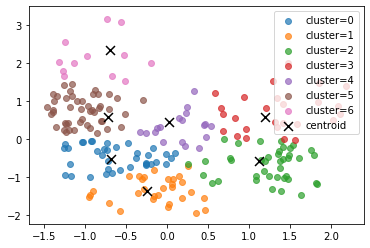

In [106]:
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',
                   names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                          'asymmetry_coefficient', 'length_kernel_groove', 'target'], usecols=[0, 5],
                   sep='\t+', engine='python')

#data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

# Initialization and training
som_shape = (1, 7)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.9, learning_rate=.7,
              neighborhood_function='gaussian', random_seed=10)

som.train(data, 500, verbose=True)

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x',
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();